In [ ]:
#!pip install mediapipe

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import math
import random
from PIL import Image

from collections import Counter, defaultdict
from tqdm import tqdm

import mediapipe as mp
from sklearn.model_selection import train_test_split

In [6]:
face_forensic_path = "/kaggle/input/faceforencispp-extracted-frames"
wild_deep_fake_path = "/kaggle/input/wild-deepfake"

# Wild deep fake dataset

In [7]:
def resolution_check_wilddf(path, sample_per_video=3):
    
    resolutions = set()
    video_groups = defaultdict(list)
    
    for img_file in os.listdir(path):
        if img_file.endswith(".png"):
            vid_id = img_file.split("_")[0]
            video_groups[vid_id].append(img_file)
    
    for vid_id, imgs in video_groups.items():
        sampled_images = random.sample(imgs, min(sample_per_video, len(imgs)))
        for img_file in sampled_images:
            img_path = os.path.join(path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                h, w, _ = img.shape
                resolutions.add((w, h))
    
    return resolutions

In [8]:
def frame_distribution_summary(path_name):
    frame_counts = Counter()
    
    for file in os.listdir(path_name):
        if file.endswith(".png"):
            video_id = file.split("_")[0]
            frame_counts[video_id] += 1

    counts = list(frame_counts.values())

    print(f"Total videos detected: {len(frame_counts)}")
    print(f"Total frames: {sum(counts)}")
    print(f"Avg frames per video: {np.mean(counts):.2f}")
    print(f"Max frames in a video: {max(counts)}")
    print(f"Min frames in a video: {min(counts)}")

    plt.hist(counts, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Frame Count Distribution ({os.path.basename(path_name)})")
    plt.xlabel("Frames per Video")
    plt.ylabel("Number of Videos")
    plt.show()

Resolution of Train-Real: {(224, 224)}

Frame Distribution of Train-Real Videos: 
Total videos detected: 637
Total frames: 85517
Avg frames per video: 134.25
Max frames in a video: 641
Min frames in a video: 30


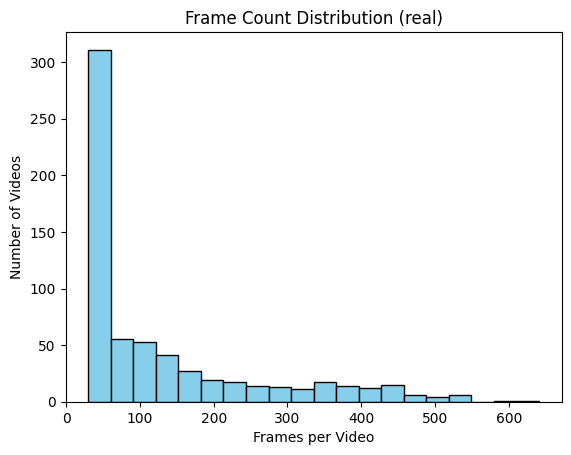



Resolution of Train-Fake: {(224, 224)}

Frame Distribution of Train-Fake Videos: 
Total videos detected: 540
Total frames: 80080
Avg frames per video: 148.30
Max frames in a video: 1145
Min frames in a video: 30


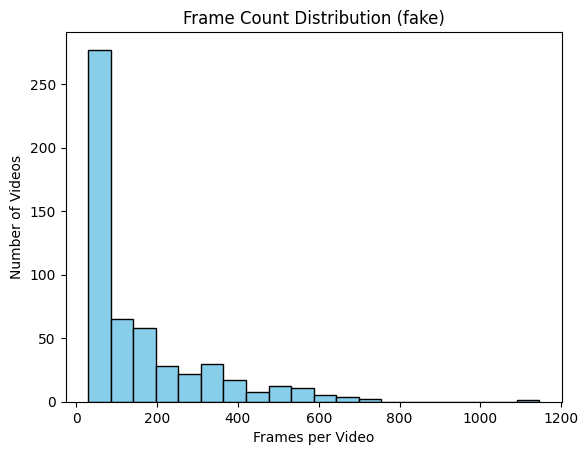

In [9]:
print(f"Resolution of Train-Real: {resolution_check_wilddf('/kaggle/input/wild-deepfake/train/real')}\n")
print(f"Frame Distribution of Train-Real Videos: ")
frame_distribution_summary('/kaggle/input/wild-deepfake/train/real')

print(f"\n\nResolution of Train-Fake: {resolution_check_wilddf('/kaggle/input/wild-deepfake/train/fake')}\n")
print(f"Frame Distribution of Train-Fake Videos: ")
frame_distribution_summary('/kaggle/input/wild-deepfake/train/fake')

Resolution of Valid-Real: {(224, 224)}

Frame Distribution of Validation-Real Videos: 
Total videos detected: 198
Total frames: 8168
Avg frames per video: 41.25
Max frames in a video: 187
Min frames in a video: 5


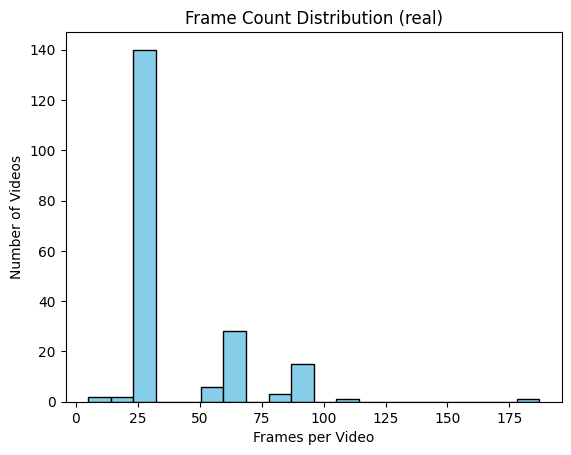



Resolution of Valid-Fake: {(224, 224)}

Frame Distribution of Validation-Fake Videos: 
Total videos detected: 167
Total frames: 9180
Avg frames per video: 54.97
Max frames in a video: 481
Min frames in a video: 5


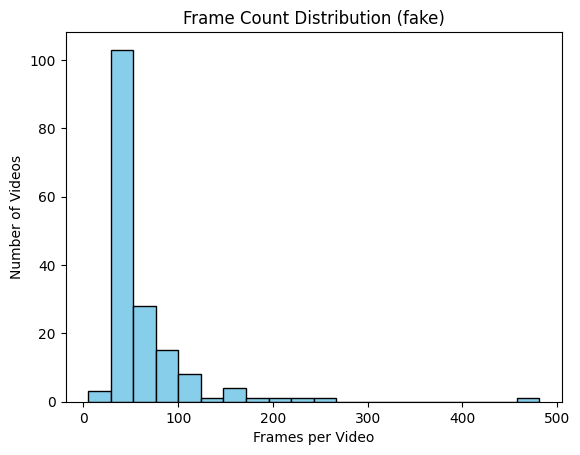

In [10]:
print(f"Resolution of Valid-Real: {resolution_check_wilddf('/kaggle/input/wild-deepfake/valid/real')}\n")
print(f"Frame Distribution of Validation-Real Videos: ")
frame_distribution_summary('/kaggle/input/wild-deepfake/valid/real')

print(f"\n\nResolution of Valid-Fake: {resolution_check_wilddf('/kaggle/input/wild-deepfake/valid/fake')}\n")
print(f"Frame Distribution of Validation-Fake Videos: ")
frame_distribution_summary('/kaggle/input/wild-deepfake/valid/fake')

Resolution of Test-Real: {(224, 224)}

Frame Distribution of Test-Real Videos: 
Total videos detected: 93
Total frames: 3370
Avg frames per video: 36.24
Max frames in a video: 90
Min frames in a video: 2


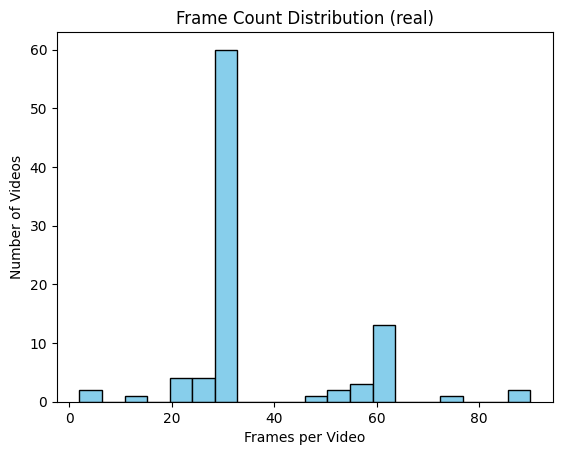



Resolution of Test-Fake: {(224, 224)}

Frame Distribution of Test-Fake Videos: 
Total videos detected: 81
Total frames: 3398
Avg frames per video: 41.95
Max frames in a video: 146
Min frames in a video: 6


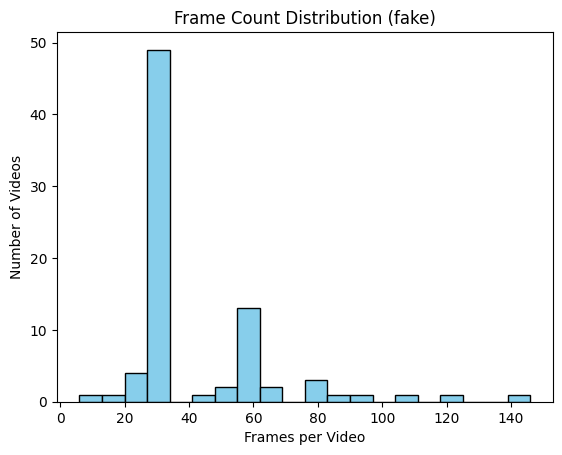

In [11]:
print(f"Resolution of Test-Real: {resolution_check_wilddf('/kaggle/input/wild-deepfake/test/real')}\n")
print(f"Frame Distribution of Test-Real Videos: ")
frame_distribution_summary('/kaggle/input/wild-deepfake/test/real')

print(f"\n\nResolution of Test-Fake: {resolution_check_wilddf('/kaggle/input/wild-deepfake/test/fake')}\n")
print(f"Frame Distribution of Test-Fake Videos: ")
frame_distribution_summary('/kaggle/input/wild-deepfake/test/fake')

# FaceForesnics++ dataset

In [12]:
real_path = "/kaggle/input/faceforencispp-extracted-frames/real"

Face2Face_path = "/kaggle/input/faceforencispp-extracted-frames/fake/Face2Face"
Deepfakes_path = "/kaggle/input/faceforencispp-extracted-frames/fake/Deepfakes"
FaceShifter_path = "/kaggle/input/faceforencispp-extracted-frames/fake/FaceShifter"
FaceSwap_path = "/kaggle/input/faceforencispp-extracted-frames/fake/FaceSwap"
NeuralTextures_path = "/kaggle/input/faceforencispp-extracted-frames/fake/NeuralTextures"

In [13]:
def resolution_check(path, sample_per_video=3):
    resolutions = set()
    
    for video_path in os.listdir(path):
        video_folder = os.path.join(path, video_path)
        image_files = os.listdir(video_folder)
        
        sampled_images = random.sample(image_files, min(sample_per_video, len(image_files)))
        
        for img_file in sampled_images:
            img_path = os.path.join(video_folder, img_file)
            img = cv2.imread(img_path)
            
            if img is not None:
                h, w, _ = img.shape
                resolutions.add((w, h))
    
    return resolutions

In [14]:
def frame_distribution(path_name):
    path_list = os.listdir(path_name)
    frame_counts = []

    for path_num in path_list:
        num_frames = len(os.listdir(os.path.join(path_name, path_num)))
        frame_counts.append(num_frames)
    
    return dict(Counter(frame_counts))

## Real

In [15]:
print(f"Number of Videos: {len(os.listdir(real_path))}")

print(f"Frame Distribution of Real Videos: {frame_distribution(real_path)}")

Number of Videos: 999
Frame Distribution of Real Videos: {32: 985, 31: 12, 28: 1, 29: 1}


In [16]:
print(f"Resolution: {resolution_check(real_path)}")

Resolution: {(256, 256)}


## Deepfakes

In [17]:
print(f"Number of videos in Deepfakes: {len(os.listdir(Deepfakes_path))}")

print(f"Frame Distribution of Deepfakes Videos: {frame_distribution(Deepfakes_path)}")

Number of videos in Deepfakes: 999
Frame Distribution of Deepfakes Videos: {32: 967, 27: 1, 21: 1, 31: 18, 14: 1, 30: 5, 28: 2, 17: 1, 29: 1, 2: 1, 25: 1}


In [18]:
print(f"Resolution: {resolution_check(Deepfakes_path)}")

Resolution: {(256, 256)}


## Face2Face

In [19]:
print(f"Number of videos in Face2Face: {len(os.listdir(Face2Face_path))}")

print(f"Frame Distribution of Face2Face Videos: {frame_distribution(Face2Face_path)}")

Number of videos in Face2Face: 999
Frame Distribution of Face2Face Videos: {32: 989, 31: 5, 29: 2, 30: 2, 28: 1}


In [20]:
print(f"Resolution: {resolution_check(Face2Face_path)}")

Resolution: {(256, 256)}


## FaceShifter

In [21]:
print(f"Number of videos in FaceShifter: {len(os.listdir(FaceShifter_path))}")

print(f"Frame Distribution of FaceShifter Videos: {frame_distribution(FaceShifter_path)}")

Number of videos in FaceShifter: 999
Frame Distribution of FaceShifter Videos: {32: 982, 30: 2, 31: 10, 19: 1, 27: 2, 29: 1, 28: 1}


In [22]:
print(f"Resolution: {resolution_check(FaceShifter_path)}")

Resolution: {(256, 256)}


## FaceSwap

In [23]:
print(f"Number of videos in FaceSwap: {len(os.listdir(FaceSwap_path))}")

print(f"Frame Distribution of FaceSwap Videos: {frame_distribution(FaceSwap_path)}")

Number of videos in FaceSwap: 1000
Frame Distribution of FaceSwap Videos: {32: 981, 31: 13, 30: 2, 29: 3, 12: 1}


In [24]:
print(f"Resolution: {resolution_check(FaceSwap_path)}")

Resolution: {(256, 256)}


## NeuralTextures

In [25]:
print(f"Number of videos in NeuralTextures: {len(os.listdir(NeuralTextures_path))}")

print(f"Frame Distribution of NeuralTextures Videos: {frame_distribution(NeuralTextures_path)}")

Number of videos in NeuralTextures: 999
Frame Distribution of NeuralTextures Videos: {32: 985, 31: 8, 29: 2, 30: 2, 17: 1, 28: 1}


In [26]:
print(f"Resolution: {resolution_check(NeuralTextures_path)}")

Resolution: {(256, 256)}


# Class Imbalance

In [27]:
print(f"Number of fake videos: {999+999+1000+999+999}")
print(f"Number of real videos: {999}")
print(f"Total videos: {999+999+1000+999+999+999}")
print(f"\nClass Imbalance of real vs fake: {math.ceil(999/4996*100)}:{math.ceil(4996/4996*100)}")

Number of fake videos: 4996
Number of real videos: 999
Total videos: 5995

Class Imbalance of real vs fake: 20:100


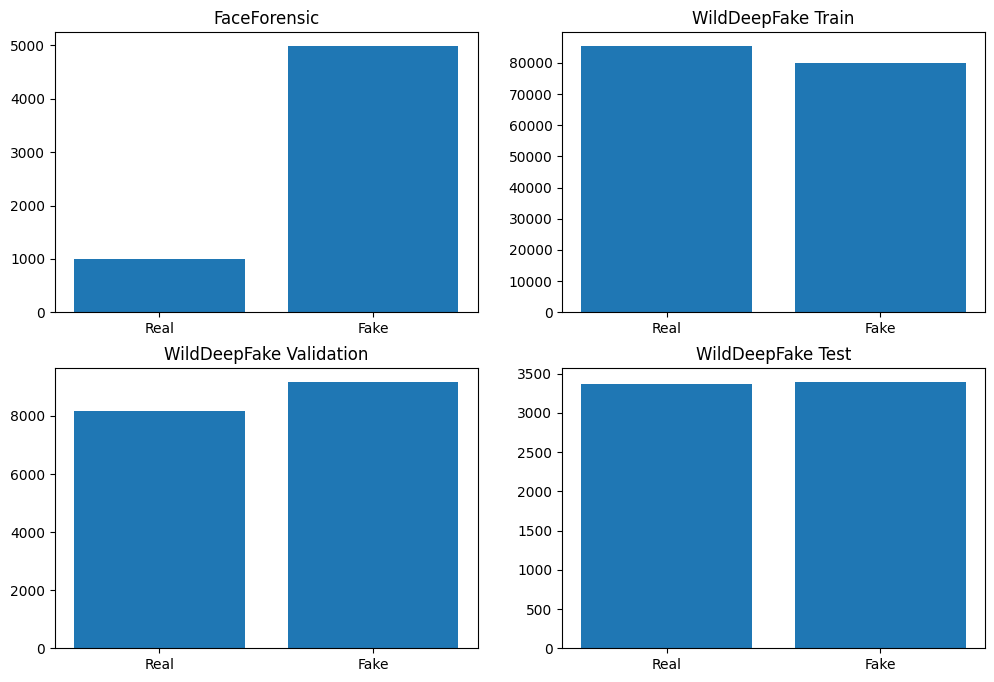

In [28]:
categories = ["Real", "Fake"]

face_values = [999, 4996]

wild_train_values = [85517, 80080]
wild_valid_values = [8168, 9180]
wild_test_values = [3370, 3398]

fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()

ax[0].bar(categories, face_values)
ax[0].set_title("FaceForensic")

ax[1].bar(categories, wild_train_values)
ax[1].set_title("WildDeepFake Train")

ax[2].bar(categories, wild_valid_values)
ax[2].set_title("WildDeepFake Validation")

ax[3].bar(categories, wild_test_values)
ax[3].set_title("WildDeepFake Test")

plt.show()

# Face Presence

In [29]:
mp_face = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)

def verify_faces_mediapipe(dataset_path, sample_per_video=5):
    total_videos = len(os.listdir(dataset_path))
    videos_with_faces = 0
    videos_without_faces = 0

    for video_folder in tqdm(os.listdir(dataset_path), total=total_videos):
        video_path = os.path.join(dataset_path, video_folder)
        image_files = [f for f in os.listdir(video_path) if f.endswith('.png')]
        if not image_files:
            videos_without_faces += 1
            continue

        # Randomly sample a few frames
        sample_frames = image_files[:sample_per_video]
        has_face = False

        for img_name in sample_frames:
            img_path = os.path.join(video_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = mp_face.process(img_rgb)

            if result.detections:
                has_face = True
                break

        if has_face:
            videos_with_faces += 1
        else:
            videos_without_faces += 1

    return {
        "total_videos": total_videos,
        "with_faces": videos_with_faces,
        "without_faces": videos_without_faces
    }

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [30]:
real_stats = verify_faces_mediapipe(real_path)

W0000 00:00:1761415358.589205     110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 999/999 [00:20<00:00, 48.89it/s]


In [31]:
Face2Face_stats = verify_faces_mediapipe(Face2Face_path)
Deepfakes_stats = verify_faces_mediapipe(Deepfakes_path)
FaceShifter_stats = verify_faces_mediapipe(FaceShifter_path)
FaceSwap_stats = verify_faces_mediapipe(FaceSwap_path)
Neural_stats = verify_faces_mediapipe(NeuralTextures_path)

100%|██████████| 999/999 [00:20<00:00, 49.76it/s]


In [32]:
print("Real video face presence:", real_stats)
print("Face2Face video face presence:", Face2Face_stats)
print("Deepfakes video face presence:", Deepfakes_stats)
print("Face Shifter video face presence:", FaceShifter_stats)
print("Face Swap video face presence:", FaceSwap_stats)
print("Neural Textures video face presence:", Neural_stats)

Real video face presence: {'total_videos': 999, 'with_faces': 999, 'without_faces': 0}
Face2Face video face presence: {'total_videos': 999, 'with_faces': 999, 'without_faces': 0}
Deepfakes video face presence: {'total_videos': 999, 'with_faces': 999, 'without_faces': 0}
Face Shifter video face presence: {'total_videos': 999, 'with_faces': 999, 'without_faces': 0}
Face Swap video face presence: {'total_videos': 1000, 'with_faces': 1000, 'without_faces': 0}
Neural Textures video face presence: {'total_videos': 999, 'with_faces': 999, 'without_faces': 0}


# Preprocessing

In [46]:
def get_valid_videos(base_path, expected_frames=32):
    data = []
    
    for label in ["real", "fake"]:
        label_path = os.path.join(base_path, label)
        
        if label == "fake":
            fake_types = os.listdir(label_path)
            
            for ftype in fake_types:
                ftype_path = os.path.join(label_path, ftype)
                
                for video_folder in os.listdir(ftype_path):
                    video_path = os.path.join(ftype_path, video_folder)
                    frame_count = len(os.listdir(video_path))
                    
                    if frame_count == expected_frames:
                        data.append({
                            "label": "fake",
                            "type": ftype,
                            "path": video_path,
                            "video_folder": video_folder,
                            "frames": frame_count
                        })
        else:
            for video_folder in os.listdir(label_path):
                video_path = os.path.join(label_path, video_folder)
                frame_count = len(os.listdir(video_path))
                
                if frame_count == expected_frames:
                    data.append({
                        "label": "real",
                        "type": "real",
                        "path": video_path,
                        "video_folder": video_folder,
                        "frames": frame_count
                    })
    
    return pd.DataFrame(data)

In [47]:
df = get_valid_videos(face_forensic_path)

In [48]:
df.head()

,label,type,path,video_folder,frames
0,real,real,/kaggle/input/faceforencispp-extracted-frames/...,437,32
1,real,real,/kaggle/input/faceforencispp-extracted-frames/...,515,32
2,real,real,/kaggle/input/faceforencispp-extracted-frames/...,248,32
3,real,real,/kaggle/input/faceforencispp-extracted-frames/...,625,32
4,real,real,/kaggle/input/faceforencispp-extracted-frames/...,843,32


In [49]:
print(df.shape)
df.info()

(5889, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5889 entries, 0 to 5888
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         5889 non-null   object
 1   type          5889 non-null   object
 2   path          5889 non-null   object
 3   video_folder  5889 non-null   object
 4   frames        5889 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 230.2+ KB


In [51]:
print(df.label.unique())
print(df.type.unique())
print(df.frames.unique())
print(df.video_folder.nunique())
print(df.path.nunique())

['real' 'fake']
['real' 'Face2Face' 'Deepfakes' 'NeuralTextures' 'FaceShifter' 'FaceSwap']
[32]
1980
5889


In [52]:
def extract_source_id(path):
    video_path = (os.path.basename(path))
    return video_path.split('_')[0]

In [53]:
df['source_id'] = df['video_folder'].apply(extract_source_id)

print(f"Number of unique source IDs: {df['source_id'].nunique()}")

Number of unique source IDs: 995


In [54]:
real_df = df[df["label"] == "real"].copy()
fake_df = df[df["label"] == "fake"].copy()

print(fake_df["type"].value_counts())

type
Face2Face         989
NeuralTextures    985
FaceShifter       982
FaceSwap          981
Deepfakes         967
Name: count, dtype: int64


In [63]:
real_df["type"].value_counts()

type
real    985
Name: count, dtype: int64

In [55]:
fake_balanced_dfs = []

for ftype in fake_df['type'].unique():
    ftype_df = fake_df[fake_df['type'] == ftype]
    
    # Sample SOURCE IDs first (not videos!)
    source_ids = ftype_df['source_id'].unique()
    sampled_sources = np.random.choice(
        source_ids,
        size=min(600, len(source_ids)),
        replace=False
    )
    
    # Get all videos from sampled sources
    sampled_ftype = ftype_df[ftype_df['source_id'].isin(sampled_sources)]
    fake_balanced_dfs.append(sampled_ftype)
    print(f"{ftype}: {len(sampled_ftype)} videos from {len(sampled_sources)} sources")

fake_balanced = pd.concat(fake_balanced_dfs, ignore_index=True)
balanced_df = pd.concat([real_df, fake_balanced], ignore_index=True)

Face2Face: 600 videos from 600 sources
Deepfakes: 600 videos from 600 sources
NeuralTextures: 600 videos from 600 sources
FaceShifter: 600 videos from 600 sources
FaceSwap: 600 videos from 600 sources


In [56]:
train_sources, temp_sources = train_test_split(source_ids,test_size=0.3,random_state=42)

val_sources, test_sources = train_test_split(temp_sources,test_size=0.5,random_state=42)

In [57]:
train_df = balanced_df[balanced_df['source_id'].isin(train_sources)].copy()
val_df = balanced_df[balanced_df['source_id'].isin(val_sources)].copy()
test_df = balanced_df[balanced_df['source_id'].isin(test_sources)].copy()

## Data Leakage Check

In [58]:
def extract_source_id(path):
    video_path = (os.path.basename(path))
    return video_path.split('_')[0]


# Add source IDs
train_df['source_id'] = train_df['path'].apply(extract_source_id)
val_df['source_id'] = val_df['path'].apply(extract_source_id)
test_df['source_id'] = test_df['path'].apply(extract_source_id)

# Check for overlap
train_sources = set(train_df['source_id'].unique())
val_sources = set(val_df['source_id'].unique())
test_sources = set(test_df['source_id'].unique())

train_val_overlap = train_sources & val_sources
train_test_overlap = train_sources & test_sources
val_test_overlap = val_sources & test_sources

print(f"Train sources: {len(train_sources)}")
print(f"Val sources: {len(val_sources)}")
print(f"Test sources: {len(test_sources)}")
print(f"\n❌ Train-Val overlap: {len(train_val_overlap)} sources")
print(f"❌ Train-Test overlap: {len(train_test_overlap)} sources")
print(f"❌ Val-Test overlap: {len(val_test_overlap)} sources")

if train_val_overlap or train_test_overlap or val_test_overlap:
    print("\n🚨 DATA LEAKAGE DETECTED! Your splits are invalid!")
else:
    print("\n✅ No leakage - splits are clean")

Train sources: 686
Val sources: 147
Test sources: 148

❌ Train-Val overlap: 0 sources
❌ Train-Test overlap: 0 sources
❌ Val-Test overlap: 0 sources

✅ No leakage - splits are clean


## Split Statistics

In [59]:
print(f"\n{'='*50}")
print("SPLIT STATISTICS:")
print(f"{'='*50}")
print(f"Train: {len(train_df)} videos")
print(train_df['type'].value_counts())
print(f"\nVal: {len(val_df)} videos")
print(val_df['type'].value_counts())
print(f"\nTest: {len(test_df)} videos")
print(test_df['type'].value_counts())


LEAKAGE CHECK:
Train sources: 686
Val sources: 147
Test sources: 148

Train-Val overlap: 0 sources
Train-Test overlap: 0 sources
Val-Test overlap: 0 sources
✅ NO LEAKAGE DETECTED - Splits are valid!

SPLIT STATISTICS:
Train: 2758 videos
type
real              679
Deepfakes         422
FaceShifter       420
FaceSwap          420
NeuralTextures    415
Face2Face         402
Name: count, dtype: int64

Val: 597 videos
type
real              147
Face2Face          97
FaceShifter        94
FaceSwap           92
NeuralTextures     86
Deepfakes          81
Name: count, dtype: int64

Test: 587 videos
type
real              148
Face2Face          91
NeuralTextures     91
Deepfakes          89
FaceSwap           88
FaceShifter        80
Name: count, dtype: int64


In [64]:
train_df.to_csv("/kaggle/working/train_metadata.csv", index=False)
val_df.to_csv("/kaggle/working/val_metadata.csv", index=False)
test_df.to_csv("/kaggle/working/test_metadata.csv", index=False)

# Corrupt Images

In [68]:
def check_image_integrity(df, sample_size=10000):
    """Check if random sample of images can be loaded"""
    sampled = df.sample(min(sample_size, len(df)))
    corrupted = []
    
    for _, row in sampled.iterrows():
        video_path = row['path']
        frames = os.listdir(video_path)
        
        # Check first and last frame
        for frame in [frames[0], frames[-1]]:
            img_path = os.path.join(video_path, frame)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify it's a valid image
                img = Image.open(img_path)  # Re-open after verify
                img.load()  # Actually load the data
            except Exception as e:
                corrupted.append({
                    'path': img_path,
                    'error': str(e)
                })
    
    if corrupted:
        print(f" {len(corrupted)} corrupted images found!")
        print(pd.DataFrame(corrupted).head())
        return False
    else:
        print(f" All sampled images are valid")
        return True

check_image_integrity(train_df, sample_size=100000)

 All sampled images are valid


True